# Set Up

In [1]:
%pwd

'/pscratch/sd/m/mansisak/memorization/figs'

In [2]:
!module load conda

In [3]:
!conda activate /pscratch/sd/m/mansisak/memorization/env/

In [4]:
!ls /pscratch/sd/m/mansisak/memorization/model_ckpts/EleutherAI_edit/

act	localization_results_108000.csv  mem_seq_pythia-2.8b-deduped
attrib	localization_results_143000.csv  mem_seq_pythia-6.9b-deduped
greedy	localization_results_36000.csv	 slim
hc	localization_results_72000.csv


In [5]:
ls 

lm_bd_reg.pdf              math_bd_train_loss.pdf
lm_bd_test_perplexity.pdf  math_bd_train.pdf
lm_bd_train_loss.pdf       math_noise_reg.pdf
lm_bd_train.pdf            math_noise_test_acc.pdf
lm_dup_noise_train.pdf     math_noise_train_loss.pdf
lm_noise_reg.pdf           math_noise_train.pdf
math_bd_reg.pdf            pythia_unlearning_results.ipynb
math_bd_test_acc.pdf


In [6]:
import pandas as pd
import numpy as np
import torch
import copy
import seaborn as sns
import matplotlib.pyplot as plt

# Load in Results + Visualize Tables of unlearning @ different time points/models

In [7]:
result_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/EleutherAI_edit/"

file_name = "localization_results_72000.csv"

df = pd.read_csv(f'{result_path}{file_name}')

base_stats = df.loc[0].copy()
df = df.drop_duplicates()
df.head()

,model_name,localization_method,ratio,batch_size,epochs,lambda_l1,stop_loss,lr,prompt_len,ig_steps,momentum,weight_decay,step,assess_mem,seed,model_path,results_path,perc,perp,unlearn_set_name
0,EleutherAI/pythia-6.9b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,0.9,0.0005,72000,0,0,../../model_ckpts/EleutherAI/pythia-6.9b-deduped,../../model_ckpts/EleutherAI_edit/localization...,0.564356,20.980392,NaN
1,EleutherAI/pythia-6.9b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,0.9,0.0005,72000,0,0,../../model_ckpts/EleutherAI/pythia-6.9b-deduped,../../model_ckpts/EleutherAI_edit/localization...,0.281188,21.607843,mem
2,EleutherAI/pythia-6.9b-deduped,act,0.010,32,1,1000,0.1,0.1,32,1,0.9,0.0005,72000,0,0,../../model_ckpts/EleutherAI/pythia-6.9b-deduped,../../model_ckpts/EleutherAI_edit/localization...,0.164356,23.372549,mem
3,EleutherAI/pythia-6.9b-deduped,act,0.050,32,1,1000,0.1,0.1,32,1,0.9,0.0005,72000,0,0,../../model_ckpts/EleutherAI/pythia-6.9b-deduped,../../model_ckpts/EleutherAI_edit/localization...,0.108911,25.411765,mem
4,EleutherAI/pythia-6.9b-deduped,hc,0.001,32,1,1000,0.1,0.1,32,1,0.9,0.0005,72000,0,0,../../model_ckpts/EleutherAI/pythia-6.9b-deduped,../../model_ckpts/EleutherAI_edit/localization...,0.512871,21.568627,mem


In [8]:
df[df['unlearn_set_name'].isna()]

,model_name,localization_method,ratio,batch_size,epochs,lambda_l1,stop_loss,lr,prompt_len,ig_steps,momentum,weight_decay,step,assess_mem,seed,model_path,results_path,perc,perp,unlearn_set_name
0,EleutherAI/pythia-6.9b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,0.9,0.0005,72000,0,0,../../model_ckpts/EleutherAI/pythia-6.9b-deduped,../../model_ckpts/EleutherAI_edit/localization...,0.564356,20.980392,NaN
24,EleutherAI/pythia-2.8b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,0.9,0.0005,72000,0,1,../../model_ckpts/EleutherAI/pythia-2.8b-deduped,../../model_ckpts/EleutherAI_edit/localization...,0.372277,23.509804,NaN
26,EleutherAI/pythia-2.8b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,0.9,0.0005,72000,0,0,../../model_ckpts/EleutherAI/pythia-2.8b-deduped,../../model_ckpts/EleutherAI_edit/localization...,0.372277,23.509804,NaN
28,EleutherAI/pythia-2.8b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,0.9,0.0005,72000,0,3,../../model_ckpts/EleutherAI/pythia-2.8b-deduped,../../model_ckpts/EleutherAI_edit/localization...,0.372277,23.509804,NaN


In [9]:
import statistics
import math
def return_ideal_method_for_lang(base_early_stats, weight_early, backdoor=False):
  #desired columns
  cols = ["perc", "perp",'localization_method','ratio']

  #Convert base stats to a df
  base_frame = base_early_stats.to_frame().T[cols]

  #Generate Percent Differences
  weight_early["perc_diff"] =  (weight_early['perc'] - base_early_stats['perc']) /  base_early_stats['perc']


  weight_early["perp_diff"] = (weight_early['perp'] - base_early_stats['perp']) /  base_early_stats['perp']

  weight_early["score"] = 0 # zero initialize -- we will populate it below

  #Compute Scores
  for index, row in weight_early.iterrows():


    if row['unlearn_set_name'] == "mem":
        if row['perc_diff'] == 0:
            weight_early.loc[index, "score"] += 100 # this is how we penalize zero perc drop in mem
        weight_early.loc[index, "score"] += (row['perc_diff'])



        weight_early.loc[index, "score"] += statistics.mean([row['perp_diff']])

  df = pd.DataFrame(columns=cols)
  #append base stats to df
  base_frame['localization_method'] = "BASE_STATS"
  df = pd.concat([df, base_frame])

  #Print out ideal method for each dist based on the min score
  for unlearn_set in ['greedy', 'durable', 'durable_agg', 'random', 'random_greedy', "hc", "slim", 'act', ]:
    #print(unlearn_set)
    subset = weight_early.loc[weight_early['localization_method'] == unlearn_set]
    if subset.shape[0] == 0:
      #print("no results yet for: ", unlearn_set)
      continue
    sub_frame = subset[subset.score == subset.score.min()].drop_duplicates()
    sub_frame = sub_frame[cols]
    #print(sub_frame)
    df = pd.concat([df, sub_frame])

  df[['ratio',]] *= 100

  return df.drop_duplicates()


STEP:  36000  model_name:   EleutherAI/pythia-6.9b-deduped


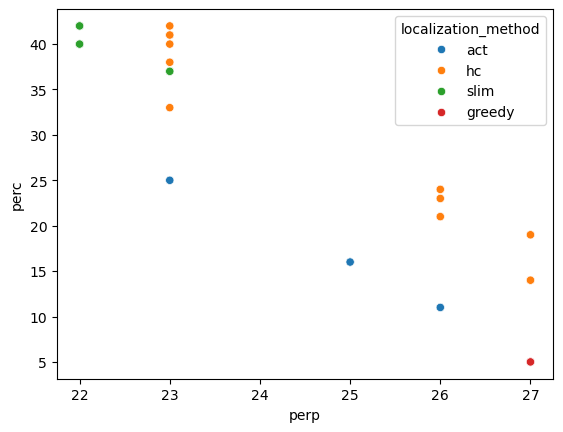

STEP:  72000  model_name:   EleutherAI/pythia-6.9b-deduped


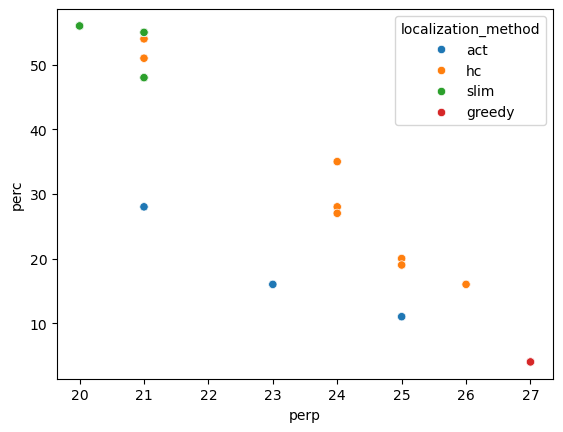

STEP:  108000  model_name:   EleutherAI/pythia-6.9b-deduped


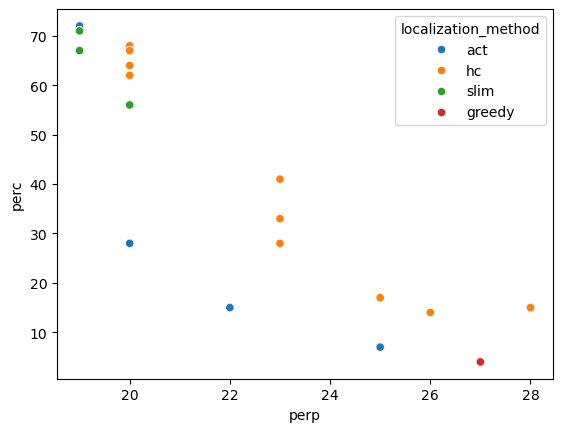

STEP:  143000  model_name:   EleutherAI/pythia-6.9b-deduped


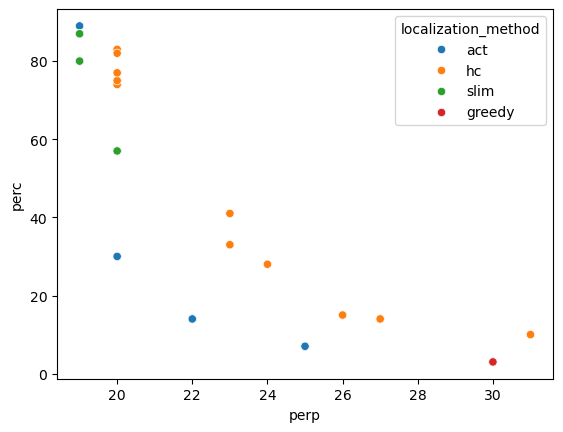

STEP:  36000  model_name:   EleutherAI/pythia-2.8b-deduped


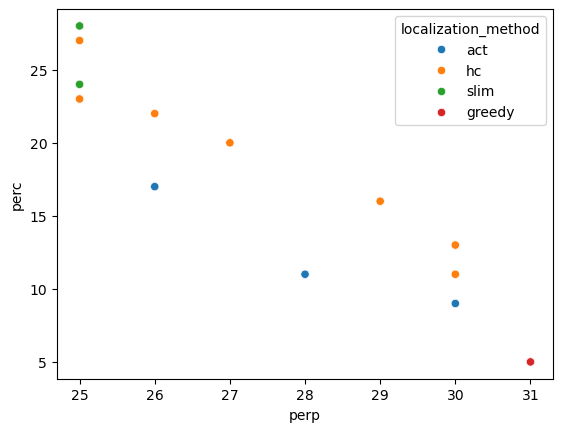

STEP:  72000  model_name:   EleutherAI/pythia-2.8b-deduped


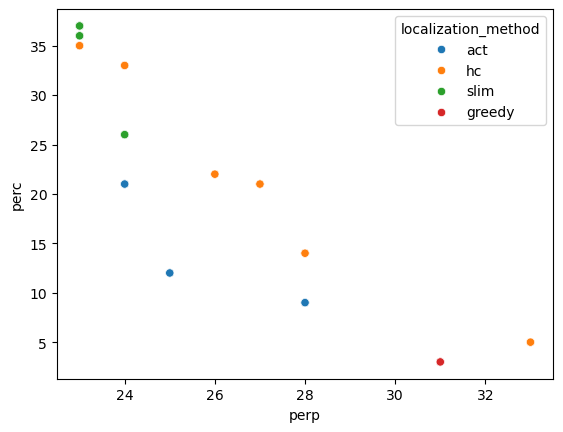

STEP:  108000  model_name:   EleutherAI/pythia-2.8b-deduped


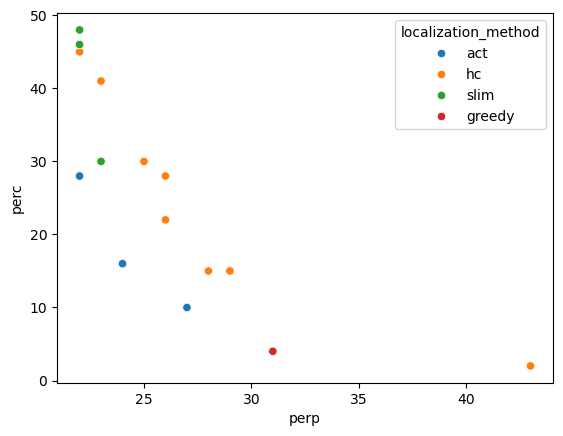

STEP:  143000  model_name:   EleutherAI/pythia-2.8b-deduped


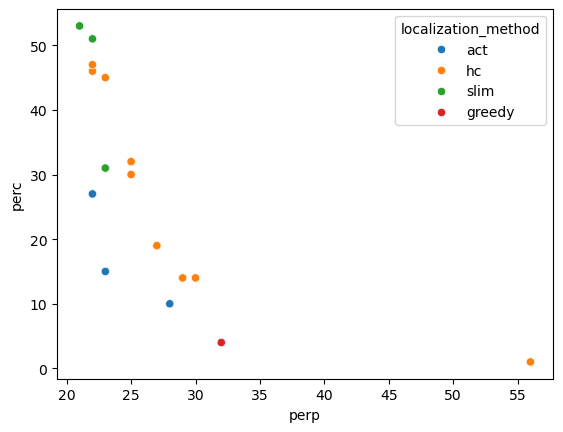

In [10]:

result_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/EleutherAI_edit/"
dfs = []
x_idx = 0
for model_name in ['EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-2.8b-deduped']:
    y_idx = 0
    for step in [36000, 72000, 108000, 143000]:
        print("STEP: ", step, " model_name:  ", model_name)
        file_name = f"localization_results_{step}.csv"

        df = pd.read_csv(f'{result_path}{file_name}')
        for col in df.columns:
            if col in ["perc"]:
                df[col] = df[col].apply(lambda x: round(x, 2))
                df[col] = df[col].apply(lambda x: int(x*100))
            if col in ["perp"]:
                df[col] = df[col].apply(lambda x: int(x))
            if col in ['ratio']:
                df[col] = df[col].apply(lambda x: round(x, 6))
        df = df[df['model_name'] == model_name]
        #base_stats = df.loc[0].copy()
        base_stats = df[df['unlearn_set_name'].isna()].iloc[0]
        df = df.drop_duplicates()
        #df = return_ideal_method_for_lang(base_stats, df, backdoor=False)
        #print(df)
        dfs.append(copy.deepcopy(df))
        sns.scatterplot(x="perp",
                y="perc",
                data=df,
                hue="localization_method")
        plt.show()

STEP:  36000  model_name:   EleutherAI/pythia-6.9b-deduped
0 0
STEP:  72000  model_name:   EleutherAI/pythia-6.9b-deduped
1 0
STEP:  108000  model_name:   EleutherAI/pythia-6.9b-deduped
2 0
STEP:  143000  model_name:   EleutherAI/pythia-6.9b-deduped
3 0
STEP:  36000  model_name:   EleutherAI/pythia-2.8b-deduped
0 1
STEP:  72000  model_name:   EleutherAI/pythia-2.8b-deduped
1 1
STEP:  108000  model_name:   EleutherAI/pythia-2.8b-deduped
2 1
STEP:  143000  model_name:   EleutherAI/pythia-2.8b-deduped
3 1


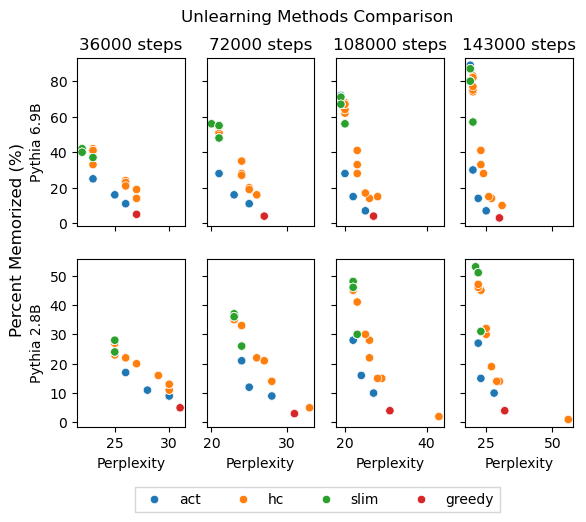

In [11]:
fig, axs = plt.subplots( 2, 4, sharex='col', sharey='row')
fig.suptitle('Unlearning Methods Comparison')
fig.supylabel("Percent Memorized (%)")


y_idx = 0
x_idx = 0

result_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/EleutherAI_edit/"
dfs = []
x_idx = 0
for model_name in ['EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-2.8b-deduped']:
    y_idx = 0
    for step in [36000, 72000, 108000, 143000]:
        print("STEP: ", step, " model_name:  ", model_name)
        file_name = f"localization_results_{step}.csv"

        df = pd.read_csv(f'{result_path}{file_name}')
        for col in df.columns:
            if col in ["perc"]:
                df[col] = df[col].apply(lambda x: round(x, 2))
                df[col] = df[col].apply(lambda x: int(x*100))
            if col in ["perp"]:
                df[col] = df[col].apply(lambda x: int(x))
            if col in ['ratio']:
                df[col] = df[col].apply(lambda x: round(x, 6))
        df = df[df['model_name'] == model_name]
        #base_stats = df.loc[0].copy()
        base_stats = df[df['unlearn_set_name'].isna()].iloc[0]
        df = df.drop_duplicates()
        #df = return_ideal_method_for_lang(base_stats, df, backdoor=False)
        #print(df)
        dfs.append(copy.deepcopy(df))
        ax = sns.scatterplot(x="perp",
                y="perc",
                data=df,
                hue="localization_method", ax=axs[x_idx, y_idx])
        ax.set_xlabel("Perplexity")
        ax.set_ylabel("Percent Memorized (%)")
        ax.get_legend().remove()

        print(y_idx, x_idx)
        y_idx += 1
    x_idx += 1

rows = ["Pythia 6.9B", "Pythia 2.8B"]
for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row)

cols = [36000, 72000, 108000, 143000]
for ax, col in zip(axs[0], cols):
    ax.set_title(f'{col} steps')
        #plt.show()

#fig.legend(lines, labels, loc = (0.5, 0), ncol=5)
handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center')
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, -0.0),fancybox=False, shadow=False, ncol=4)

In [12]:
result_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/EleutherAI_edit/"
dfs = []
for model_name in ['EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-2.8b-deduped']:
    for step in [36000, 72000, 108000, 143000]:
        print("STEP: ", step, " model_name:  ", model_name)
        file_name = f"localization_results_{step}.csv"

        df = pd.read_csv(f'{result_path}{file_name}')
        for col in df.columns:
            if col in ["perc"]:
                df[col] = df[col].apply(lambda x: round(x, 2))
                df[col] = df[col].apply(lambda x: int(x*100))
            if col in ["perp"]:
                df[col] = df[col].apply(lambda x: int(x))
            if col in ['ratio']:
                df[col] = df[col].apply(lambda x: round(x, 6))
        df = df[df['model_name'] == model_name]
        #base_stats = df.loc[0].copy()
        base_stats = df[df['unlearn_set_name'].isna()].iloc[0]
        df = df.drop_duplicates()
        dfs.append(copy.deepcopy(df))

        df = return_ideal_method_for_lang(base_stats, df, backdoor=False)
        print(df)
        print(df.to_latex())

STEP:  36000  model_name:   EleutherAI/pythia-6.9b-deduped
    perc perp localization_method  ratio
0     42   22          BASE_STATS    0.1
128    5   27              greedy  0.001
11    14   27                  hc    5.0
19    37   23                slim    5.0
3     11   26                 act    5.0
\begin{tabular}{lllll}
\toprule
 & perc & perp & localization_method & ratio \\
\midrule
0 & 42 & 22 & BASE_STATS & 0.100000 \\
128 & 5 & 27 & greedy & 0.001000 \\
11 & 14 & 27 & hc & 5.000000 \\
19 & 37 & 23 & slim & 5.000000 \\
3 & 11 & 26 & act & 5.000000 \\
\bottomrule
\end{tabular}

STEP:  72000  model_name:   EleutherAI/pythia-6.9b-deduped


/tmp/ipykernel_524782/4188130009.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.40476190476190477' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])
/tmp/ipykernel_524782/4188130009.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])


    perc perp localization_method  ratio
0     56   20          BASE_STATS    0.1
130    4   27              greedy  0.001
11    16   26                  hc    5.0
19    48   21                slim    5.0
2     16   23                 act    1.0
\begin{tabular}{lllll}
\toprule
 & perc & perp & localization_method & ratio \\
\midrule
0 & 56 & 20 & BASE_STATS & 0.100000 \\
130 & 4 & 27 & greedy & 0.001000 \\
11 & 16 & 26 & hc & 5.000000 \\
19 & 48 & 21 & slim & 5.000000 \\
2 & 16 & 23 & act & 1.000000 \\
\bottomrule
\end{tabular}

STEP:  108000  model_name:   EleutherAI/pythia-6.9b-deduped
    perc perp localization_method  ratio
0     72   19          BASE_STATS    0.1
131    4   27              greedy  0.001
12    17   25                  hc    5.0
19    56   20                slim    5.0
2     15   22                 act    1.0
\begin{tabular}{lllll}
\toprule
 & perc & perp & localization_method & ratio \\
\midrule
0 & 72 & 19 & BASE_STATS & 0.100000 \\
131 & 4 & 27 & greedy & 0.00100

/tmp/ipykernel_524782/4188130009.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.6111111111111112' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])
/tmp/ipykernel_524782/4188130009.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.6629213483146067' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])
/tmp/ipykernel_524782/4188130009.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.39285714285714285' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])
/tmp/ipykernel_524782/41881300

    perc perp localization_method  ratio
22    48   22          BASE_STATS    0.1
128    4   31              greedy  0.001
60    15   28                  hc    5.0
81    30   23                slim    5.0
30    16   24                 act    1.0
\begin{tabular}{lllll}
\toprule
 & perc & perp & localization_method & ratio \\
\midrule
22 & 48 & 22 & BASE_STATS & 0.100000 \\
128 & 4 & 31 & greedy & 0.001000 \\
60 & 15 & 28 & hc & 5.000000 \\
81 & 30 & 23 & slim & 5.000000 \\
30 & 16 & 24 & act & 1.000000 \\
\bottomrule
\end{tabular}

STEP:  143000  model_name:   EleutherAI/pythia-2.8b-deduped
    perc perp localization_method  ratio
26    53   21          BASE_STATS    0.1
125    4   32              greedy  0.001
46    19   27                  hc    1.0
108   31   23                slim    5.0
33    15   23                 act    1.0
\begin{tabular}{lllll}
\toprule
 & perc & perp & localization_method & ratio \\
\midrule
26 & 53 & 21 & BASE_STATS & 0.100000 \\
125 & 4 & 32 & greedy & 0.00

/tmp/ipykernel_524782/4188130009.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.49056603773584906' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])


Text(0.5, 1.0, 'Unlearning method comparision accorss models + timepoints')

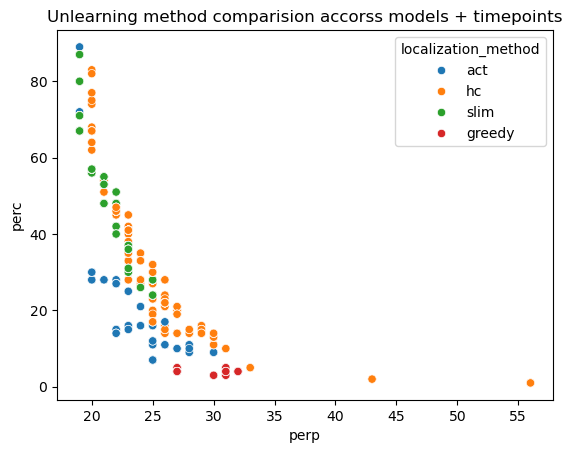

In [13]:
super_df = pd.concat(dfs, axis=0)
sns.scatterplot(x="perp",
                y="perc",
                data=super_df,
                hue="localization_method")
plt.title("Unlearning method comparision accorss models + timepoints")

# Unlearn Accross Time

In [14]:
seq_before = []
seq_after = []
ckpt_dir = "/pscratch/sd/m/mansisak/memorization/model_ckpts/"
steps = [108000, 143000]
for step in steps:

    #load original mem set
    mem_seq_original = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/mem_seq_pythia-2.8b-deduped',map_location=torch.device('cpu'))
    seq_before.append(mem_seq_original)

    #load mem set after unlearning
    #mem_seq_after_edit = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/act/mem/0.01/mem_seq_pythia-2.8b-deduped')
    #mem_seq_after_edit = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/random_greedy/mem/0.01/1/0.1/0.9/0.0005/mem_seq_pythia-2.8b-deduped')
    mem_seq_after_edit = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/hc/mem/0.01/1/1000/0.1/0.1/mem_seq_pythia-2.8b-deduped',map_location=torch.device('cpu'))
    seq_after.append(mem_seq_after_edit)

In [15]:
def get_common_mem_seq_at_all_time(seq_before):
    #bc we unlearn at different time points, we want to find a common subset of points that is memorized at each training set
    
    base_mem_seq = seq_before[0] # the earliest timepiont has fewest mem seqence
    common_seqs = []
    for row in base_mem_seq: #iterate thru all rows of base mem seq
        common = False
        for seq in seq_before: #see if later time points contain it
            if row in seq:
                common=True
                
        if common:
            common_seqs.append(copy.deepcopy(row))
    
    return torch.stack(common_seqs, dim=0)

In [16]:
common_seqs = get_common_mem_seq_at_all_time(seq_before)

In [17]:
common_seqs.shape #there are 80 common seqences memorized at each time point (we will compare unlearning methods on these 80 sequences

torch.Size([243, 80])

In [18]:
def check_overlap(seq_after, common_seqs, steps=steps):
    #Now we want to compare unlearning at multiple timepoints!
    not_unlearn_set_over_time = []
    for seq in seq_after:
        not_unlearn_set = []
        for row in seq:
            if row in common_seqs:
                #print("row not unlearned")
                not_unlearn_set.append(copy.deepcopy(row))
        print(torch.stack(not_unlearn_set, dim=0).shape)
        not_unlearned_set = torch.stack(not_unlearn_set, dim=0)
        not_unlearn_set_over_time.append(copy.deepcopy(not_unlearned_set))
        
    for i in range(len(steps)):
        step = steps[i]
        print(f"Perc unlearn @ step {step}: ", 100 * (common_seqs.shape[0] - not_unlearn_set_over_time[i].shape[0])/ common_seqs.shape[0], "%")
    
    return not_unlearn_set_over_time # we wnat to know how many of these sequenes were unlearned overtime
    

In [19]:
not_unlearn_set_over_time = check_overlap(seq_after, common_seqs)

torch.Size([117, 80])
torch.Size([113, 80])
Perc unlearn @ step 108000:  51.851851851851855 %
Perc unlearn @ step 143000:  53.49794238683128 %


Interestingly in the above setting, it appears the same unlearning method (act), unlearns better at later timesteps, rather than earlier timesteps

In [20]:
# interpret results!

In [21]:
not_unlearn_set_over_time[0].shape

torch.Size([117, 80])

# Git commit

In [22]:
!git add /pscratch/sd/m/mansisak/memorization/figs/pythia_unlearning_results.ipynb
!git commit -m "updated unlearning visualization/analysis"

[WARNING] Unstaged files detected.
[INFO] Stashing unstaged files to /global/u1/m/mansisak/.cache/pre-commit/patch1723606325-525593.
black................................................(no files to check)Skipped
[INFO] Restored changes from /global/u1/m/mansisak/.cache/pre-commit/patch1723606325-525593.
[main 19bfa94] updated unlearning visualization/analysis
 1 file changed, 55 insertions(+), 23 deletions(-)
